# Entrega 3 Deep Learning 
* Sebastian Bolivar
* David Rojo

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc # Garbage Collector para liberar RAM
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [2]:
# Configuración visual
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 50)

In [3]:
# Verificar ruta de datos
DATA_PATH = '../input/kkbox-churn-prediction-challenge/'
print(os.listdir(DATA_PATH))

['transactions_v2.csv.7z', 'WSDMChurnLabeller.scala', 'transactions.csv.7z', 'train.csv.7z', 'train_v2.csv.7z', 'user_logs.csv.7z', 'members_v3.csv.7z', 'sample_submission_zero.csv.7z', 'user_logs_v2.csv.7z', 'sample_submission_v2.csv.7z']


PROBLEMA CON EL ORIGEN DE LOS DATOS, ESTAN COMPRIMIDOS

In [4]:
# --- FUNCIÓN PARA REDUCIR USO DE MEMORIA ---
def reduce_mem_usage(df):
    """ Itera sobre las columnas y cambia el tipo de dato para reducir memoria """
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    return df

In [5]:
# --- DESCOMPRESIÓN DE DATOS ---
# Solo vamos a descomprimir los archivos v2 y v3 para no llenar el disco con los v1 (que son enormes)

import os

# Definir ruta de entrada y salida
INPUT_DIR = '../input/kkbox-churn-prediction-challenge/'
WORKING_DIR = './' # Directorio de trabajo actual

# Lista de archivos que necesitamos (versiones actualizadas v2/v3)
files_to_extract = [
    'train_v2.csv.7z',
    'members_v3.csv.7z',
    'transactions_v2.csv.7z',
    'user_logs_v2.csv.7z'
]

print("Descomprimiendo archivos... esto puede tardar un minuto.")
for file in files_to_extract:
    # Comprobamos si ya lo descomprimimos para no repetir
    csv_name = file.replace('.7z', '')
    if not os.path.exists(csv_name):
        print(f"Extrayendo {file}...")
        # Comando de sistema para descomprimir en el directorio actual
        os.system(f'7z e {INPUT_DIR}{file} -y')
    else:
        print(f"{csv_name} ya existe, saltando extracción.")

print("\nArchivos en el directorio de trabajo:")
print(os.listdir(WORKING_DIR))

Descomprimiendo archivos... esto puede tardar un minuto.
Extrayendo train_v2.csv.7z...

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
1 file, 32818991 bytes (32 MiB)

Extracting archive: ../input/kkbox-churn-prediction-challenge/train_v2.csv.7z
--
Path = ../input/kkbox-churn-prediction-challenge/train_v2.csv.7z
Type = 7z
Physical Size = 32818991
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       45635134
Compressed: 32818991
Extrayendo members_v3.csv.7z...

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
1 file, 242308558 bytes (232 MiB)

Extracting archive: ../input/kkbox-churn-prediction

In [6]:
# 2. CARGA Y PROCESAMIENTO DE TABLAS
# ------------------------------------------------------------------------------
print("\n--- 2. Cargando y procesando tablas ---")

# --- A) TRAIN (Etiquetas) ---
# Usamos train_v2.csv que corresponde al periodo de user_logs_v2
train = pd.read_csv('./train_v2.csv')
train = reduce_mem_usage(train)
print(f"Train cargado: {train.shape}")

# --- B) MEMBERS (Datos demográficos) ---
members = pd.read_csv('./members_v3.csv')
members = reduce_mem_usage(members)
print(f"Members cargado: {members.shape}")


# --- C) TRANSACTIONS (Historial de pagos) ---
transactions = pd.read_csv('./transactions_v2.csv')
transactions = reduce_mem_usage(transactions)

# Ingeniería de Features para Transactions (Baseline):
# Ordenamos por usuario y fecha para quedarnos con la ÚLTIMA transacción conocida.
transactions = transactions.sort_values(by=['msno', 'transaction_date'], ascending=[True, True])
trans_last = transactions.groupby('msno').last().reset_index()

# Feature: Descuento obtenido (Precio de lista - Precio pagado)
trans_last['discount'] = trans_last['plan_list_price'] - trans_last['actual_amount_paid']
# Feature: ¿Es autorenovable? (ya viene como int/bool, aseguramos int)
trans_last['is_auto_renew'] = trans_last['is_auto_renew'].astype(int)
# Feature: Duración del plan pagado
trans_last['paid_duration'] = trans_last['payment_plan_days']

# Seleccionamos columnas útiles del último pago
cols_trans = ['msno', 'payment_method_id', 'payment_plan_days', 'plan_list_price', 
              'actual_amount_paid', 'is_auto_renew', 'is_cancel', 'discount', 'paid_duration']
trans_last = trans_last[cols_trans]

print(f"Transactions procesado (una fila por usuario): {trans_last.shape}")

# Limpieza para liberar RAM
del transactions
gc.collect()

# --- D) USER LOGS (Comportamiento de escucha) ---
logs = pd.read_csv('./user_logs_v2.csv')
logs = reduce_mem_usage(logs)

# Ingeniería de Features para Logs (Baseline):
# Colapsamos la serie temporal en promedios y totales por usuario
logs_agg = logs.groupby('msno').agg({
    'date': 'count',               # Días activos en el periodo
    'num_25': 'sum',               # Total canciones escuchadas < 25%
    'num_50': 'sum',
    'num_100': 'sum',              # Total canciones completas
    'num_unq': 'mean',             # Promedio diario de canciones únicas
    'total_secs': 'sum'            # Tiempo total escuchado
}).reset_index()

logs_agg.columns = ['msno', 'active_days', 'total_25', 'total_50', 'total_100', 'avg_unique_daily', 'total_secs_all']

# Feature derivada: Ratio de completitud (¿Termina lo que empieza?)
logs_agg['completion_ratio'] = logs_agg['total_100'] / (logs_agg['total_25'] + logs_agg['total_50'] + logs_agg['total_100'] + 1)

print(f"User Logs procesado (una fila por usuario): {logs_agg.shape}")

# Limpieza
del logs
gc.collect()


--- 2. Cargando y procesando tablas ---
Memory usage of dataframe is 14.82 MB
Memory usage after optimization is: 8.33 MB
Decreased by 43.7%
Train cargado: (970960, 2)
Memory usage of dataframe is 309.88 MB
Memory usage after optimization is: 154.94 MB
Decreased by 50.0%
Members cargado: (6769473, 6)
Memory usage of dataframe is 98.26 MB
Memory usage after optimization is: 34.12 MB
Decreased by 65.3%
Transactions procesado (una fila por usuario): (1197050, 9)
Memory usage of dataframe is 1263.18 MB
Memory usage after optimization is: 526.32 MB
Decreased by 58.3%
User Logs procesado (una fila por usuario): (1103894, 8)


24

In [7]:
# 3. MERGE Y PREPARACIÓN FINAL (X, y)
# ------------------------------------------------------------------------------
print("\n--- 3. Uniendo datasets (Merge) ---")


--- 3. Uniendo datasets (Merge) ---



--- ¡DATASET LISTO! ---
X shape: (970960, 19)
y shape: (970960,)
Tasa de Churn: 8.99%


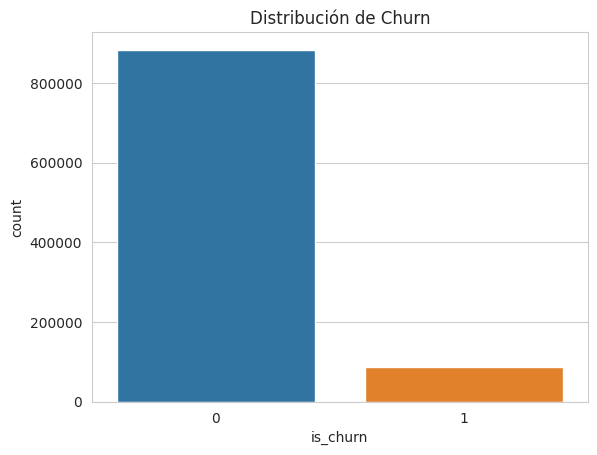

In [8]:
# Unimos todo a la tabla Train (Left Join para no perder usuarios del train set)
df_final = train.merge(members, on='msno', how='left')
df_final = df_final.merge(trans_last, on='msno', how='left')
df_final = df_final.merge(logs_agg, on='msno', how='left')

# Manejo de nulos (IMPORTANTE):
# Si no hay logs o transacciones, asumimos 0 actividad o valores por defecto.
numeric_cols = df_final.select_dtypes(include=[np.number]).columns
df_final[numeric_cols] = df_final[numeric_cols].fillna(0)

# Columnas a eliminar para el entrenamiento
# 'msno': es el ID, no predictivo.
# Fechas: requieren procesamiento complejo, las quitamos para el baseline rápido.
cols_drop = ['msno', 'transaction_date', 'membership_expire_date', 'registration_init_time', 'date']
features_drop = [c for c in cols_drop if c in df_final.columns]

X = df_final.drop(columns=['is_churn'] + features_drop)
y = df_final['is_churn']

# Codificación simple para 'gender' si existe
if 'gender' in X.columns:
    X['gender'] = X['gender'].map({'male': 1, 'female': 0}).fillna(-1)

print("\n--- ¡DATASET LISTO! ---")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Tasa de Churn: {y.mean():.2%}")

# Visualización rápida del target
sns.countplot(x=y)
plt.title("Distribución de Churn")
plt.show()

# EDA

In [9]:
# 1. PREPARACIÓN
# ------------------------------------------------------------------------------
# Unimos X e y temporalmente para facilitar el plot con Seaborn
df_eda = X.copy()
df_eda['target_churn'] = y
print("Dataset preparado para EDA. Dimensiones:", df_eda.shape)

# Configuración estética
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


Dataset preparado para EDA. Dimensiones: (970960, 20)



--- 1. Matriz de Correlación (Top variables) ---
target_churn          1.000000
is_cancel             0.378018
payment_plan_days     0.268859
paid_duration         0.268859
plan_list_price       0.259759
actual_amount_paid    0.257410
gender                0.103565
city                  0.088410
bd                    0.071844
discount              0.063173
avg_unique_daily      0.003666
total_50             -0.007012
completion_ratio     -0.007148
total_25             -0.008523
registered_via       -0.014833
total_100            -0.018765
total_secs_all       -0.019582
active_days          -0.044684
is_auto_renew        -0.480344
payment_method_id    -0.513299
Name: target_churn, dtype: float64


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


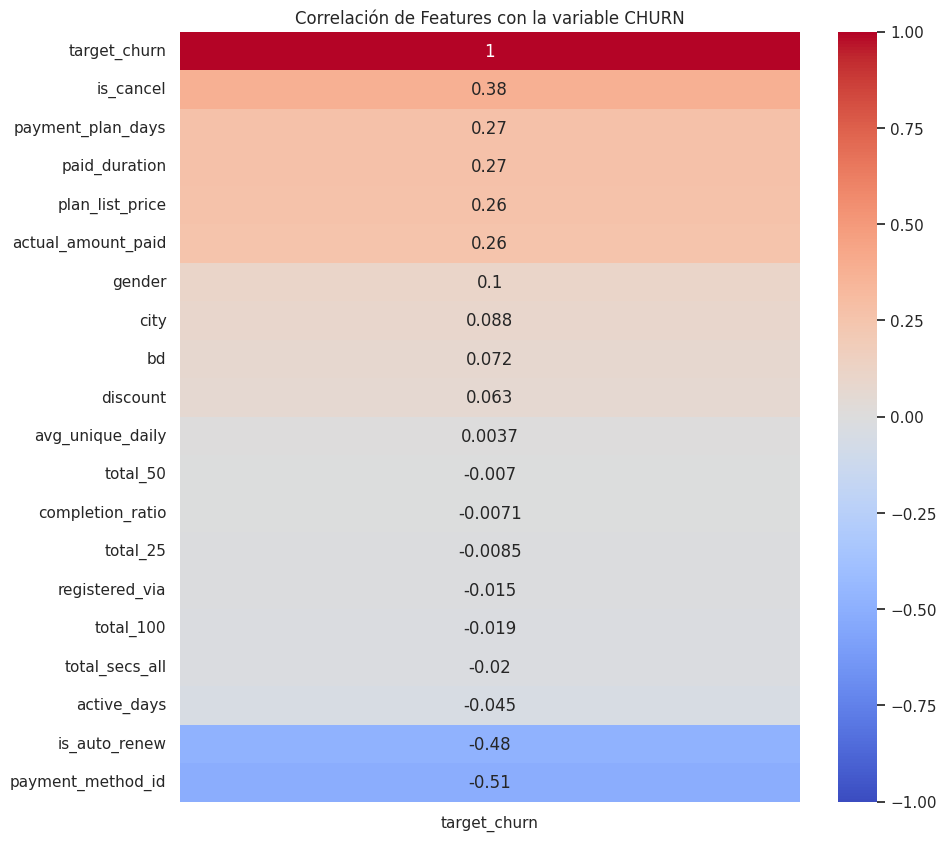

In [10]:
# 2. ANÁLISIS DE CORRELACIÓN (Mapa de calor)
# ------------------------------------------------------------------------------
# Calculamos la correlación de todas las variables con el target
print("\n--- 1. Matriz de Correlación (Top variables) ---")
corr_matrix = df_eda.corr()

# Filtramos para mostrar solo las correlaciones con 'target_churn' ordenadas
churn_corr = corr_matrix['target_churn'].sort_values(ascending=False)
print(churn_corr)

# Graficamos el mapa de calor centrado en 0
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix[['target_churn']].sort_values(by='target_churn', ascending=False),
            annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Correlación de Features con la variable CHURN")
plt.show()


--- 2. Impacto del Comportamiento (Logs) en el Churn ---


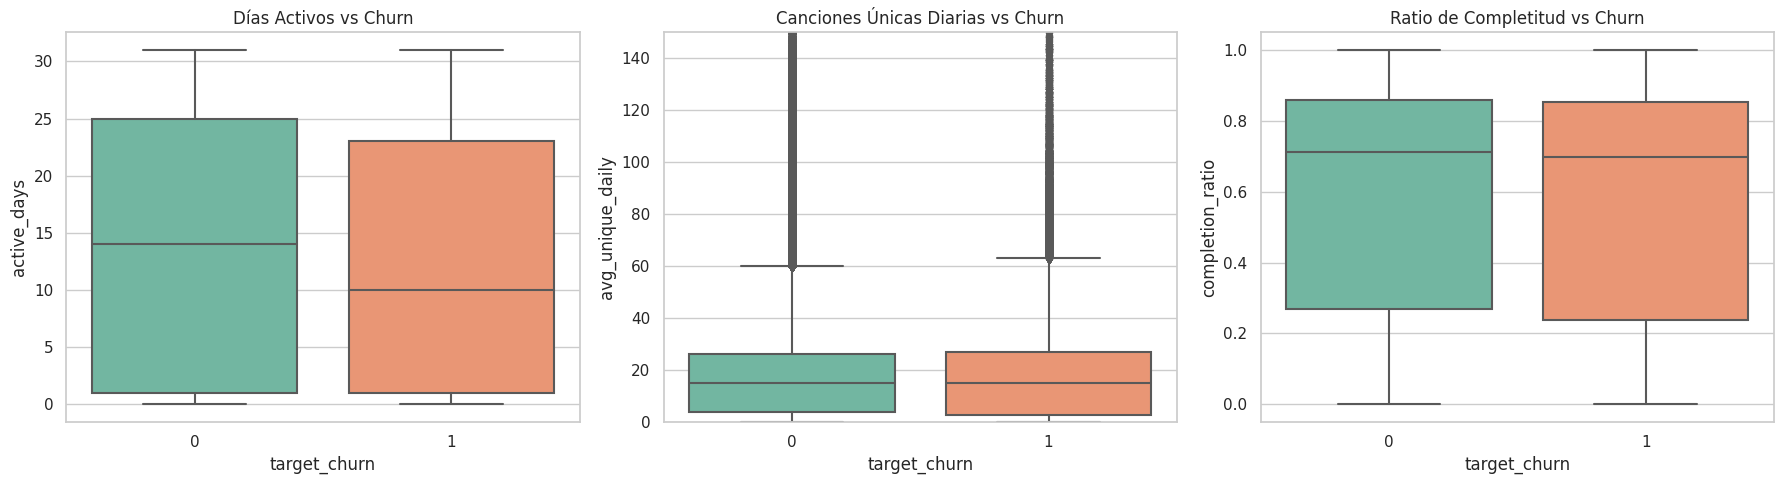

In [11]:
# 3. ANÁLISIS DE ENGAGEMENT (User Logs)
# ------------------------------------------------------------------------------
print("\n--- 2. Impacto del Comportamiento (Logs) en el Churn ---")
# Hipótesis: Quien hace churn escucha menos música o menos días.

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# A) Días Activos
sns.boxplot(x='target_churn', y='active_days', data=df_eda, ax=axes[0], palette="Set2")
axes[0].set_title('Días Activos vs Churn')

# B) Promedio diario de canciones únicas
# Usamos escala logarítmica si hay outliers muy grandes, o limitamos el eje Y
sns.boxplot(x='target_churn', y='avg_unique_daily', data=df_eda, ax=axes[1], palette="Set2")
axes[1].set_ylim(0, 150) # Zoom para ver mejor la caja principal
axes[1].set_title('Canciones Únicas Diarias vs Churn')

# C) Ratio de completitud (¿Terminan las canciones?)
sns.boxplot(x='target_churn', y='completion_ratio', data=df_eda, ax=axes[2], palette="Set2")
axes[2].set_title('Ratio de Completitud vs Churn')

plt.tight_layout()
plt.show()


--- 3. Impacto de las Transacciones ---


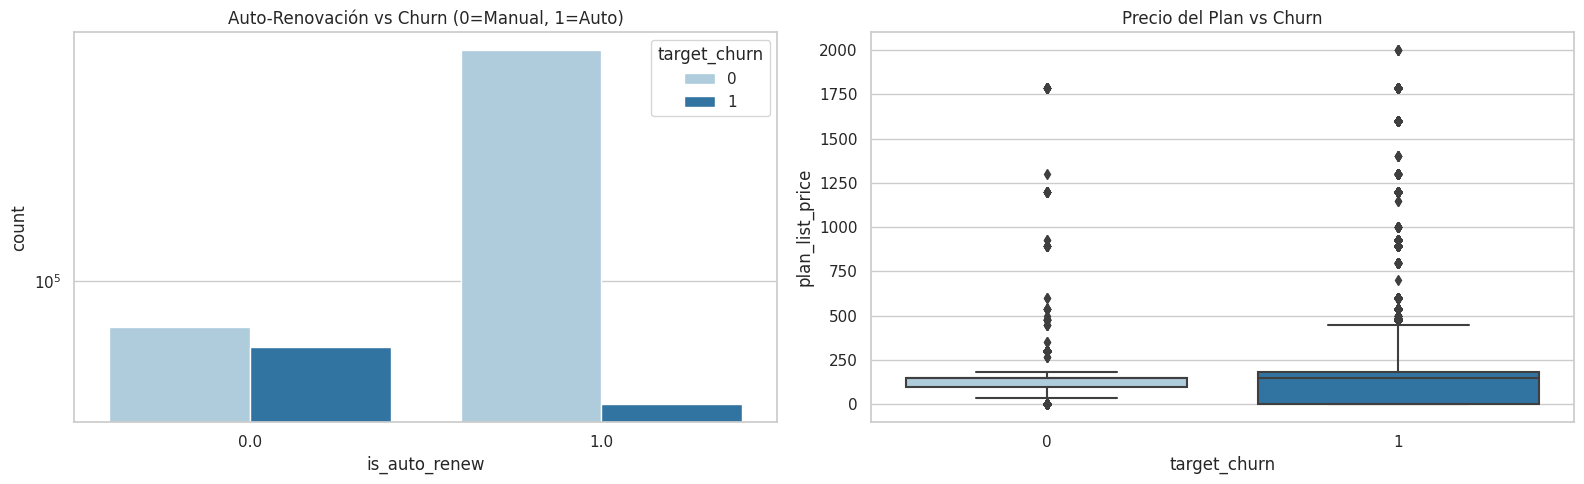

In [12]:
# 4. ANÁLISIS TRANSACCIONAL (El dinero manda)
# ------------------------------------------------------------------------------
print("\n--- 3. Impacto de las Transacciones ---")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# A) ¿Es Auto-Renovable? (Variable categórica muy fuerte)
sns.countplot(x='is_auto_renew', hue='target_churn', data=df_eda, ax=axes[0], palette="Paired")
axes[0].set_title('Auto-Renovación vs Churn (0=Manual, 1=Auto)')
axes[0].set_yscale('log') # Escala logarítmica porque el desbalance es visualmente grande

# B) Precio del plan
sns.boxplot(x='target_churn', y='plan_list_price', data=df_eda, ax=axes[1], palette="Paired")
axes[1].set_title('Precio del Plan vs Churn')

plt.tight_layout()
plt.show()


--- 4. Edad (BD) vs Churn ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

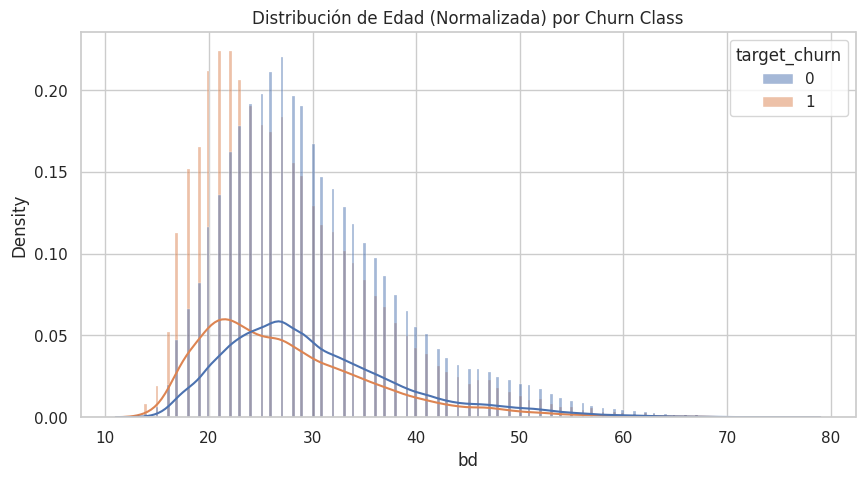

17715

In [13]:
# 5. ANÁLISIS DEMOGRÁFICO (Limpieza de Edad en vivo)
# ------------------------------------------------------------------------------
print("\n--- 4. Edad (BD) vs Churn ---")
# KKBOX tiene muchos outliers en edad (0, <0, >100). Filtramos solo para el gráfico.
df_age = df_eda[(df_eda['bd'] > 10) & (df_eda['bd'] < 80)]

plt.figure(figsize=(10, 5))
sns.histplot(data=df_age, x='bd', hue='target_churn', kde=True, stat="density", common_norm=False)
plt.title('Distribución de Edad (Normalizada) por Churn Class')
plt.show()

# Limpieza de memoria
del df_eda, df_age
import gc
gc.collect()

### Resumen de Hallazgos
El churn en KKBOX está dominado, en una primera capa, por la inercia transaccional (cómo pagan) más que por el volumen total de uso. Sin embargo, las métricas de comportamiento agregadas (promedios) muestran una correlación casi nula, lo que sugiere que el patrón de abandono es sutil y temporal, no un simple "escucha poco".
**Factor #1 de Retención:** is_auto_renew (Correlación -0.48). Si está activado, el usuario se queda.
**Factor #1 de Riesgo:** is_cancel (Correlación +0.38). Si el usuario ha iniciado una cancelación manual antes, es muy probable que se vaya definitivamente.
**La Trampa del Promedio:** Variables como avg_unique_daily o total_secs tienen correlaciones cercanas a 0. Esto indica que mirar el promedio de 30 días no sirve. Un usuario que escucha 100 canciones hoy y 0 mañana tiene el mismo promedio que uno que escucha 50 cada día, pero su riesgo es totalmente distinto.

#### Análisis Detallado por Dimensiones

**A.** Transacciones (Señales Fuertes)
Las variables financieras son los predictores más potentes:
**Auto-renovación:** Es la barrera de salida más fuerte. El churn ocurre masivamente cuando is_auto_renew=0 (renovación manual).
**Precio (plan_list_price):** Correlación positiva (+0.26). Usuarios con planes más caros tienden a hacer más churn. Probablemente usuarios "premium" que evalúan costo-beneficio más estrictamente o promociones que expiran.
**Método de Pago (payment_method_id):** Correlación fuerte (-0.51). Ciertos métodos de pago (probablemente tarjetas de crédito vinculadas a auto-renovación) blindan contra el churn, mientras que otros (quizás pagos en efectivo en tiendas o códigos) son riesgosos.

**B.** Comportamiento / Logs (La "Caja Negra")
Justificación del Proyecto:
**Correlaciones nulas:** total_secs (-0.02), completion_ratio (-0.007). Saber "cuánto escuchó en total el último mes" no sirve para predecir churn.
**Lo que importa no es el volumen, sino la tendencia. La caída abrupta de actividad en los últimos 3 días vs. los primeros 20 días es invisible al promedio, pero será visible para una GRU/Transformer.**

**C.** Demografía
**Edad (bd):** El gráfico de densidad muestra un pico claro de riesgo en usuarios jóvenes (18-24 años). Los estudiantes o adultos jóvenes tienen presupuestos más volátiles y son más propensos a cancelar.

#### Conclusiones 

Justificación del Modelo Secuencial (Transformer/GRU):
Dado que los agregados (mean, sum) fallaron en capturar señal de los logs (correlación ~0), el modelo secuencial es obligatorio. Necesitamos capturar la degradación del servicio día a día, no el resumen mensual.
Acción: Al crear las secuencias, asegurar de incluir date o days_since_last_login como feature relativa.
**Estrategia de Feature Engineering:**
No descartar los logs: Aunque ahora parecen débiles, transfórmalos en series de tiempo (Batch, Time, Features).
Interacción Transacción-Log: Un usuario sin auto-renovación (risk) que además baja su consumo de música (trend) es una cancelación asegurada. El modelo debe cruzar estas dos señales.
Segmentación:
El modelo aprenderá muy fácil a predecir churn en usuarios sin auto-renovación. El verdadero reto (y donde tu modelo aportará valor) es detectar churn en usuarios con auto-renovación activada pero comportamiento decreciente.

In [14]:
X

,city,bd,gender,registered_via,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,discount,paid_duration,active_days,total_25,total_50,total_100,avg_unique_daily,total_secs_all,completion_ratio
0,5.0,28.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,186.0,23.0,318.0,31.636364,80598.554688,0.602273
1,13.0,20.0,1.0,3.0,36.0,30.0,180.0,180.0,0.0,0.0,0.0,30.0,6.0,0.0,4.0,26.0,5.000000,6986.508789,0.838710
2,13.0,18.0,1.0,3.0,15.0,90.0,300.0,300.0,0.0,0.0,0.0,90.0,20.0,239.0,57.0,205.0,21.600000,67810.468750,0.408367
3,1.0,0.0,-1.0,7.0,41.0,30.0,149.0,149.0,1.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,13.0,35.0,0.0,7.0,41.0,30.0,99.0,99.0,1.0,0.0,0.0,30.0,15.0,9.0,7.0,962.0,36.533333,239882.234375,0.982635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970955,13.0,28.0,1.0,7.0,40.0,30.0,149.0,149.0,1.0,0.0,0.0,30.0,24.0,48.0,7.0,318.0,12.125000,77031.437500,0.850267
970956,1.0,0.0,-1.0,7.0,41.0,30.0,99.0,99.0,1.0,0.0,0.0,30.0,5.0,43.0,8.0,22.0,10.800000,8697.066406,0.297297
970957,1.0,0.0,-1.0,7.0,41.0,30.0,99.0,99.0,1.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
970958,5.0,25.0,0.0,9.0,39.0,30.0,149.0,149.0,1.0,0.0,0.0,30.0,23.0,33.0,10.0,336.0,13.434783,79499.242188,0.884211


In [15]:
y

0         1
1         1
2         1
3         1
4         1
         ..
970955    0
970956    0
970957    0
970958    0
970959    0
Name: is_churn, Length: 970960, dtype: int8

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_valid.shape, y_train.mean(), y_valid.mean())

(776768, 19) (194192, 19) 0.08994191315811156 0.08994191315811156


## Baseline 1: Logistic Regression bien hecha (one-hot + scaling)

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve

# Separar columnas numéricas vs categóricas (por dtype)
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

# Además, trata como categóricas estas columnas ID (aunque sean int)
id_like = [c for c in ['city','registered_via','payment_method_id'] if c in X.columns]
for c in id_like:
    if c in num_cols:
        num_cols.remove(c)
        cat_cols.append(c)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

logreg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1
)

clf = Pipeline(steps=[("prep", preprocess), ("model", logreg)])
clf.fit(X_train, y_train)

p_valid = clf.predict_proba(X_valid)[:, 1]

print("ROC-AUC:", roc_auc_score(y_valid, p_valid))
print("PR-AUC:", average_precision_score(y_valid, p_valid))

ROC-AUC: 0.934365484239623
PR-AUC: 0.7801588233503017


## Baseline 2: XGBoost (rápido y fuerte)

In [18]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score

xgb_clf = xgb.XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    tree_method="hist",
    eval_metric="aucpr"
)

xgb_pipe = Pipeline(steps=[("prep", preprocess), ("model", xgb_clf)])
xgb_pipe.fit(X_train, y_train)

p_valid_xgb = xgb_pipe.predict_proba(X_valid)[:, 1]
print("XGB ROC-AUC:", roc_auc_score(y_valid, p_valid_xgb))
print("XGB PR-AUC:", average_precision_score(y_valid, p_valid_xgb))

XGB ROC-AUC: 0.9451370461609092
XGB PR-AUC: 0.828639955107046


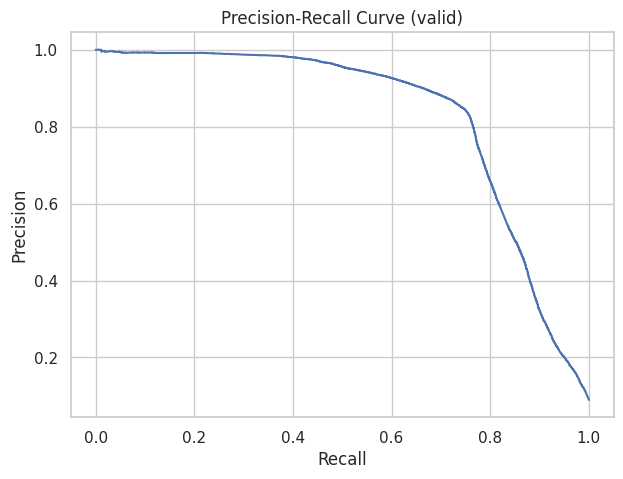

In [19]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

prec, rec, thr = precision_recall_curve(y_valid, p_valid_xgb)  # o p_valid (logreg)
plt.figure(figsize=(7,5))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve (valid)")
plt.grid(True)
plt.show()

# Version Finall:

In [36]:
import os, gc, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

import torch
print("CUDA:", torch.cuda.is_available(), "| n_gpus:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# === Paths Kaggle ===
INPUT_DIR = '../input/kkbox-churn-prediction-challenge/'
WORKING_DIR = './'

# === Prototipo ===
PROTOTYPE = True
N_USERS_PROTO = 200_000
TARGET_CHURN_PROTO = None   # None = respeta churn real; o pon 0.10 si quieres balancear prototipo

# === Secuencia ===
T = 30   # ablation: 60

# === Columns logs ===
LOG_BASE = ["num_25","num_50","num_75","num_985","num_100","num_unq","total_secs"]

# === Data limits ===
LOG_END = pd.Timestamp("2017-03-31")  # user_logs_v2 llega hasta acá
print("Config:", dict(PROTOTYPE=PROTOTYPE, N_USERS_PROTO=N_USERS_PROTO, TARGET_CHURN_PROTO=TARGET_CHURN_PROTO, T=T, LOG_END=str(LOG_END.date())))


CUDA: True | n_gpus: 2
GPU: Tesla T4
Config: {'PROTOTYPE': True, 'N_USERS_PROTO': 200000, 'TARGET_CHURN_PROTO': None, 'T': 30, 'LOG_END': '2017-03-31'}


In [37]:
files_to_extract = [
    'train_v2.csv.7z',
    'members_v3.csv.7z',
    'transactions_v2.csv.7z',
    'user_logs_v2.csv.7z'
]

print("Descomprimiendo archivos... esto puede tardar un minuto.")
for file in files_to_extract:
    csv_name = file.replace('.7z', '')
    if not os.path.exists(csv_name):
        print(f"Extrayendo {file}...")
        os.system(f'7z e {INPUT_DIR}{file} -y')
    else:
        print(f"{csv_name} ya existe, saltando extracción.")

print("\nArchivos en el directorio de trabajo:")
print(os.listdir(WORKING_DIR))


Descomprimiendo archivos... esto puede tardar un minuto.
train_v2.csv ya existe, saltando extracción.
members_v3.csv ya existe, saltando extracción.
transactions_v2.csv ya existe, saltando extracción.
user_logs_v2.csv ya existe, saltando extracción.

Archivos en el directorio de trabajo:
['user_logs_v2.csv', 'members_v3.csv', 'train_v2.csv', 'transactions_v2.csv', '.virtual_documents']


In [38]:
train_full = pd.read_csv("./train_v2.csv", usecols=["msno","is_churn"])
print("train_full:", train_full.shape, "| churn:", float(train_full.is_churn.mean()))

trans = pd.read_csv("./transactions_v2.csv")

for c in ["transaction_date","membership_expire_date"]:
    trans[c] = pd.to_datetime(trans[c].astype(str), format="%Y%m%d", errors="coerce")
trans = trans.dropna(subset=["transaction_date","membership_expire_date"]).copy()

# defensivo: filtra expiraciones absurdas (en esta comp hay algunas)
EXP_MIN = pd.Timestamp("2015-01-01")
EXP_MAX = pd.Timestamp("2017-06-30")
trans = trans[(trans.membership_expire_date >= EXP_MIN) & (trans.membership_expire_date <= EXP_MAX)].copy()

trans = trans.sort_values(["msno","transaction_date"])
print("trans:", trans.shape, "| tx_date max:", trans.transaction_date.max(), "| exp max:", trans.membership_expire_date.max())


train_full: (970960, 2) | churn: 0.08994191315811156
trans: (1241149, 9) | tx_date max: 2017-03-31 00:00:00 | exp max: 2017-06-30 00:00:00


In [39]:
def build_anchors_from_expiry_month(trans_df, month_start, month_end):
    # filtra transacciones cuyo membership_expire_date cae en el mes
    tm = trans_df[(trans_df.membership_expire_date >= month_start) & (trans_df.membership_expire_date < month_end)].copy()
    if len(tm) == 0:
        return pd.DataFrame(columns=["msno","t0","anchor_txn_date","start_seq"])

    # t0 por usuario = max expiry en el mes
    t0_by_user = (tm.groupby("msno")["membership_expire_date"]
                    .max()
                    .reset_index()
                    .rename(columns={"membership_expire_date":"t0"}))

    # anchor_txn_date = última transaction_date asociada a ese t0 (si hay varias filas con mismo t0)
    tmp = tm.merge(t0_by_user, on="msno", how="inner")
    tmp = tmp[tmp.membership_expire_date == tmp.t0]
    anchor_txn = (tmp.groupby("msno")["transaction_date"]
                    .max()
                    .reset_index()
                    .rename(columns={"transaction_date":"anchor_txn_date"}))

    anchors = t0_by_user.merge(anchor_txn, on="msno", how="left")
    anchors["start_seq"] = anchors["t0"] - pd.to_timedelta(T-1, unit="D")
    return anchors

candidates = [
    ("FEB_2017", pd.Timestamp("2017-02-01"), pd.Timestamp("2017-03-01")),
    ("MAR_2017", pd.Timestamp("2017-03-01"), pd.Timestamp("2017-04-01")),
]

train_msnos = set(train_full.msno.values)

best = None
best_overlap = -1
best_anchors = None
for name, a, b in candidates:
    anchors = build_anchors_from_expiry_month(trans, a, b)
    overlap = anchors.msno.isin(train_msnos).sum()
    print(f"{name}: anchors_users={len(anchors)} | overlap_with_train={overlap} | overlap_rate={(overlap/max(1,len(anchors))):.4f}")
    if overlap > best_overlap:
        best_overlap = overlap
        best = (name, a, b)
        best_anchors = anchors

ANCHOR_NAME, ANCHOR_START, ANCHOR_END = best
anchors_all = best_anchors.copy()

print("\nSelected expiry-month for t0:", ANCHOR_NAME, "|", ANCHOR_START.date(), "to", (ANCHOR_END - pd.Timedelta(days=1)).date())
print("anchors_all:", anchors_all.shape, "| t0 range:", anchors_all.t0.min(), anchors_all.t0.max())
anchors_all.head()


FEB_2017: anchors_users=350 | overlap_with_train=25 | overlap_rate=0.0714
MAR_2017: anchors_users=40227 | overlap_with_train=39972 | overlap_rate=0.9937

Selected expiry-month for t0: MAR_2017 | 2017-03-01 to 2017-03-31
anchors_all: (40227, 4) | t0 range: 2017-03-01 00:00:00 2017-03-31 00:00:00


,msno,t0,anchor_txn_date,start_seq
0,++0EzISdtKY48Z0GY62jer/LFQwrNIAbADdtU5xStGY=,2017-03-31,2017-03-01,2017-03-02
1,++MRn/eFl4FPB8NdhvT9LyZXvtF8K48qS8lizaT2WDM=,2017-03-06,2017-03-06,2017-02-05
2,++boFsOAGvAI3O+P4RG9O+p7e/dF7JdGb6/b+mf0ahk=,2017-03-31,2017-03-31,2017-03-02
3,++jASTaX2hzrCvpb72mS+DFUso7vhTVvkDIxmrT3wZA=,2017-03-06,2017-03-06,2017-02-05
4,++kosgi4V03jOxcBKjM/9tPignUOxcc7jBVnZLJ+lX0=,2017-03-24,2017-03-24,2017-02-23


In [40]:
users_base = train_full.merge(
    anchors_all[["msno","t0","anchor_txn_date","start_seq"]],
    on="msno", how="inner"
).copy()

print("users_base:", users_base.shape, "| churn:", float(users_base.is_churn.mean()))

if PROTOTYPE:
    n_target = min(N_USERS_PROTO, len(users_base))
    if TARGET_CHURN_PROTO is None:
        users0 = users_base.sample(n=n_target, random_state=SEED).reset_index(drop=True)
        print("PROTO (random, keeps real churn):", users0.shape, "| churn:", float(users0.is_churn.mean()))
    else:
        pos = users_base[users_base.is_churn == 1]
        neg = users_base[users_base.is_churn == 0]

        n_pos_target = int(round(n_target * TARGET_CHURN_PROTO))
        n_neg_target = n_target - n_pos_target

        n_pos = min(len(pos), n_pos_target)
        n_neg = min(len(neg), n_neg_target)

        picked = n_pos + n_neg
        if picked < n_target:
            remaining = n_target - picked
            extra_pos = min(len(pos) - n_pos, remaining)
            n_pos += max(0, extra_pos)
            remaining = n_target - (n_pos + n_neg)
            extra_neg = min(len(neg) - n_neg, remaining)
            n_neg += max(0, extra_neg)

        users0 = pd.concat([
            pos.sample(n=n_pos, random_state=SEED),
            neg.sample(n=n_neg, random_state=SEED),
        ]).sample(frac=1, random_state=SEED).reset_index(drop=True)

        print("PROTO (stratified):", dict(n_target=n_target, n_pos=n_pos, n_neg=n_neg,
                                         churn_target=TARGET_CHURN_PROTO, churn_obtained=float(users0.is_churn.mean())))
else:
    users0 = users_base.copy()

print("users0:", users0.shape, "| churn:", float(users0.is_churn.mean()))
users0.head()


users_base: (39972, 5) | churn: 0.4846392474732313
PROTO (random, keeps real churn): (39972, 5) | churn: 0.4846392474732313
users0: (39972, 5) | churn: 0.4846392474732313


,msno,is_churn,t0,anchor_txn_date,start_seq
0,VSsAy+RkooMYEPwEv0MB2zGmhgZwOrOWFBIkeYUml5s=,0,2017-03-17,2017-03-17,2017-02-16
1,X8AcIxi0NBrlXLyDkVOw3eOGjkNCQZyeWHt2w7bY+ws=,0,2017-03-31,2017-03-01,2017-03-02
2,4xgWBEPiyu6Llh0oLULC1s+xFHXr5Q0XePRPjYiQRdw=,1,2017-03-22,2017-03-19,2017-02-21
3,uFWiwJ9Pd4C0W/CNCZQy9+TIlzjRkFBek/SQK2Xjkvg=,0,2017-03-22,2017-03-23,2017-02-21
4,CXOa57ASxgkLZj0ddBe9npYNxtgfqfnHHQCeFw7flJA=,0,2017-03-03,2017-03-03,2017-02-02


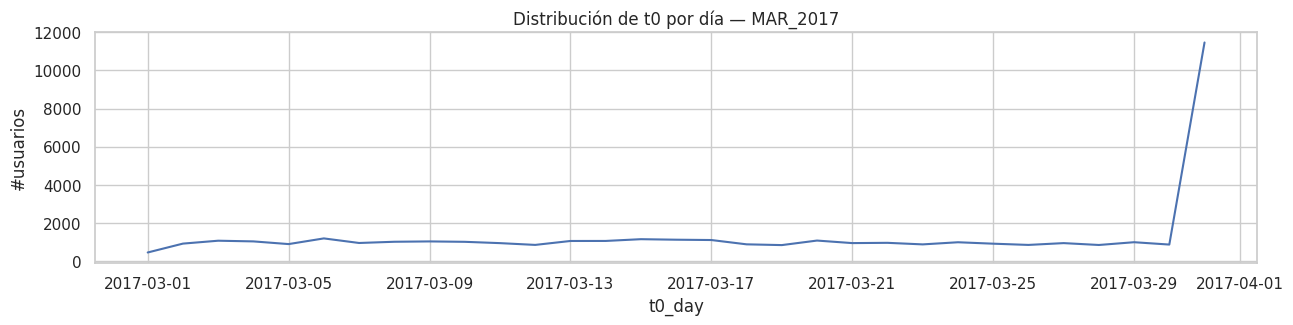

Unique t0 days: 31 | min/max: 2017-03-01 00:00:00 2017-03-31 00:00:00


3151

In [41]:
d = users0.copy()
d["t0_day"] = pd.to_datetime(d["t0"]).dt.date
daily = d.groupby("t0_day").size().reset_index(name="n")

plt.figure(figsize=(15,3))
plt.plot(pd.to_datetime(daily["t0_day"]), daily["n"])
plt.title(f"Distribución de t0 por día — {ANCHOR_NAME}")
plt.xlabel("t0_day"); plt.ylabel("#usuarios")
plt.grid(True); plt.show()

print("Unique t0 days:", daily.shape[0], "| min/max:", d.t0.min(), d.t0.max())
del d
gc.collect()

In [42]:
members = pd.read_csv("./members_v3.csv")
members = members[members.msno.isin(set(users0.msno))].copy()

if "gender" in members.columns:
    members["gender"] = members["gender"].map({"male":1, "female":0}).fillna(-1).astype(np.int8)
if "bd" in members.columns:
    members["bd"] = members["bd"].where((members["bd"]>=10) & (members["bd"]<=80), 0).fillna(0).astype(np.int16)

users = users0.merge(members, on="msno", how="left")

# trans_static: última transacción <= anchor_txn_date (más estricto que <= t0)
trans_u = trans[trans.msno.isin(set(users.msno))].copy()
trans_u = trans_u.merge(users[["msno","anchor_txn_date"]], on="msno", how="inner")
trans_u = trans_u[trans_u.transaction_date <= trans_u.anchor_txn_date].copy()
trans_u = trans_u.sort_values(["msno","transaction_date"])
trans_last_pre = trans_u.groupby("msno").tail(1).copy()

trans_last_pre["discount"] = trans_last_pre["plan_list_price"] - trans_last_pre["actual_amount_paid"]
trans_last_pre["paid_duration"] = trans_last_pre["payment_plan_days"]
trans_last_pre["is_auto_renew"] = trans_last_pre["is_auto_renew"].astype(int)

cols_trans = ["msno","payment_method_id","payment_plan_days","plan_list_price","actual_amount_paid",
              "is_auto_renew","is_cancel","discount","paid_duration"]
users = users.merge(trans_last_pre[cols_trans], on="msno", how="left")

num_cols = users.select_dtypes(include=[np.number]).columns
users[num_cols] = users[num_cols].fillna(0)

print("users final:", users.shape, "| churn:", float(users.is_churn.mean()))
print("t0 range:", users.t0.min(), users.t0.max())
users.head()

users final: (39972, 18) | churn: 0.4846392474732313
t0 range: 2017-03-01 00:00:00 2017-03-31 00:00:00


,msno,is_churn,t0,anchor_txn_date,start_seq,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,discount,paid_duration
0,VSsAy+RkooMYEPwEv0MB2zGmhgZwOrOWFBIkeYUml5s=,0,2017-03-17,2017-03-17,2017-02-16,15.0,48.0,0.0,7.0,20121222.0,41,30,100,100,1,0,0,30
1,X8AcIxi0NBrlXLyDkVOw3eOGjkNCQZyeWHt2w7bY+ws=,0,2017-03-31,2017-03-01,2017-03-02,13.0,34.0,0.0,9.0,20070324.0,37,30,149,149,1,0,0,30
2,4xgWBEPiyu6Llh0oLULC1s+xFHXr5Q0XePRPjYiQRdw=,1,2017-03-22,2017-03-19,2017-02-21,15.0,18.0,0.0,9.0,20151029.0,17,240,0,0,0,0,0,240
3,uFWiwJ9Pd4C0W/CNCZQy9+TIlzjRkFBek/SQK2Xjkvg=,0,2017-03-22,2017-03-23,2017-02-21,14.0,0.0,-1.0,9.0,20160113.0,36,30,180,180,1,1,0,30
4,CXOa57ASxgkLZj0ddBe9npYNxtgfqfnHHQCeFw7flJA=,0,2017-03-03,2017-03-03,2017-02-02,1.0,0.0,-1.0,7.0,20151004.0,41,30,99,99,1,0,0,30


In [43]:
y = users["is_churn"].values.astype(np.float32)

def temporal_split_no_ties(t0_series, valid_frac=0.2, gap_days=1):
    tkey = pd.to_datetime(t0_series).dt.normalize()
    unique_days = np.sort(pd.unique(tkey))
    b_idx = int((1 - valid_frac) * len(unique_days))
    b_idx = min(max(1, b_idx), len(unique_days)-1)
    boundary = unique_days[b_idx]

    train_mask = tkey < boundary
    valid_mask = tkey >= (boundary + pd.Timedelta(days=gap_days))
    if valid_mask.sum() == 0:
        valid_mask = tkey >= boundary

    idx_tr = np.where(train_mask.values)[0]
    idx_va = np.where(valid_mask.values)[0]
    return idx_tr, idx_va, boundary

idx_tr, idx_va, boundary = temporal_split_no_ties(users["t0"], valid_frac=0.2, gap_days=1)

print("boundary day:", boundary)
print("train/valid:", len(idx_tr), len(idx_va))
print("t0 train max:", users.loc[idx_tr, "t0"].max(), "| t0 valid min:", users.loc[idx_va, "t0"].min())
print("churn rates:", float(y[idx_tr].mean()), float(y[idx_va].mean()))

boundary day: 2017-03-25T00:00:00.000000000
train/valid: 23159 15910
t0 train max: 2017-03-24 00:00:00 | t0 valid min: 2017-03-26 00:00:00
churn rates: 0.6091800332069397 0.29805153608322144


In [44]:
msno_to_idx = dict(zip(users.msno.values, np.arange(len(users), dtype=np.int32)))

logs_path = "./user_logs_v2.csv"
header = pd.read_csv(logs_path, nrows=1)
LOG_COLS = [c for c in LOG_BASE if c in header.columns]
usecols_logs = ["msno","date"] + LOG_COLS

n_users = len(users)
n_feats = len(LOG_COLS)
print("n_users:", n_users, "n_feats:", n_feats, "LOG_COLS:", LOG_COLS)

seq_dir = "./seq_cache"
os.makedirs(seq_dir, exist_ok=True)

X_seq = np.memmap(f"{seq_dir}/X_seq_T{T}_F{n_feats}.dat", mode="w+", dtype="float32", shape=(n_users, T, n_feats))
M_seq = np.memmap(f"{seq_dir}/M_seq_T{T}.dat", mode="w+", dtype="uint8", shape=(n_users, T))

X_seq[:] = 0.0
M_seq[:] = 0
X_seq.flush(); M_seq.flush()

print("memmaps created")

n_users: 39972 n_feats: 7 LOG_COLS: ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']
memmaps created


In [45]:
start_by_uidx = users["start_seq"].values.astype("datetime64[ns]")
t0_by_uidx    = users["t0"].values.astype("datetime64[ns]")

CHUNKSIZE = 800_000 if PROTOTYPE else 2_000_000
rows_used = 0

for chunk in pd.read_csv(logs_path, usecols=usecols_logs, chunksize=CHUNKSIZE):
    chunk["uidx"] = chunk["msno"].map(msno_to_idx)
    chunk = chunk.dropna(subset=["uidx"])
    if len(chunk) == 0:
        continue
    chunk["uidx"] = chunk["uidx"].astype(np.int32)

    chunk["date"] = pd.to_datetime(chunk["date"].astype(str), format="%Y%m%d", errors="coerce")
    chunk = chunk.dropna(subset=["date"])
    if len(chunk) == 0:
        continue

    uidx = chunk["uidx"].values
    start = start_by_uidx[uidx]
    t0    = t0_by_uidx[uidx]
    d = chunk["date"].values.astype("datetime64[ns]")

    in_win = (d >= start) & (d <= t0)
    if not np.any(in_win):
        continue

    chunk = chunk.loc[in_win]
    uidx = chunk["uidx"].values.astype(np.int32)
    start = start_by_uidx[uidx]
    d = chunk["date"].values.astype("datetime64[ns]")

    day = (d - start).astype("timedelta64[D]").astype(np.int32)
    ok = (day >= 0) & (day < T)
    if not np.any(ok):
        continue

    chunk = chunk.loc[ok]
    day = day[ok]
    uidx = chunk["uidx"].values.astype(np.int32)

    for fi, col in enumerate(LOG_COLS):
        vals = chunk[col].fillna(0).values.astype(np.float32)
        np.add.at(X_seq, (uidx, day, fi), vals)

    np.maximum.at(M_seq, (uidx, day), 1)
    rows_used += len(chunk)

    del chunk
    gc.collect()

X_seq.flush(); M_seq.flush()
print("DONE rows_used:", rows_used)
print("X_seq:", X_seq.shape, "M_seq:", M_seq.shape)
print("avg active days:", float(M_seq.sum())/len(users), "out of", T)

DONE rows_used: 373404
X_seq: (39972, 30, 7) M_seq: (39972, 30)
avg active days: 9.341639147403182 out of 30


In [46]:
def compute_masked_mean_std_log1p(memX, memM, idxs, batch=2048):
    F = memX.shape[2]
    s1 = np.zeros(F, dtype=np.float64)
    s2 = np.zeros(F, dtype=np.float64)
    n  = np.zeros(F, dtype=np.float64)

    for i in range(0, len(idxs), batch):
        b = idxs[i:i+batch]
        Xb = np.array(memX[b], dtype=np.float32)
        Mb = np.array(memM[b], dtype=np.float32)
        mask = Mb[..., None]

        Xb = np.log1p(np.clip(Xb, 0, None))

        s1 += (Xb * mask).sum(axis=(0,1))
        s2 += (Xb * Xb * mask).sum(axis=(0,1))
        n  += mask.sum(axis=(0,1)).reshape(-1)

    mean = s1 / np.clip(n, 1.0, None)
    var  = s2 / np.clip(n, 1.0, None) - mean*mean
    std  = np.sqrt(np.maximum(var, 1e-6))
    return mean.astype(np.float32), std.astype(np.float32)

seq_mean, seq_std = compute_masked_mean_std_log1p(X_seq, M_seq, idx_tr, batch=2048)
print("seq_mean:", seq_mean)
print("seq_std :", seq_std)


seq_mean: [1.2659832  0.57124114 0.44356477 0.4626938  2.774469   2.86031
 8.264305  ]
seq_std : [1.092571   0.7066494  0.582095   0.60216504 1.1870538  1.0548676
 1.3222395 ]


In [47]:
from torch.utils.data import Dataset, DataLoader

col_to_i = {c:i for i,c in enumerate(LOG_COLS)}

def derived_features(x_log1p_norm):
    # x_log1p_norm: (T,F) normalizado/clipped; para ratios reconstruimos aprox
    x = torch.expm1(x_log1p_norm).clamp(min=0)

    def get(name):
        i = col_to_i.get(name, None)
        return x[:, i] if i is not None else torch.zeros(x.shape[0], device=x.device)

    total_songs = get("num_25")+get("num_50")+get("num_75")+get("num_985")+get("num_100")
    completion = get("num_100") / (total_songs + 1.0)
    unique_ratio = get("num_unq") / (total_songs + 1.0)
    secs_per_song = get("total_secs") / (total_songs + 1.0)

    extras = torch.stack([
        torch.log1p(total_songs),
        completion.clamp(0,1),
        unique_ratio.clamp(0,1),
        torch.log1p(secs_per_song.clamp(min=0))
    ], dim=1)  # (T,4)
    return extras

static_cols = ["city","bd","gender","registered_via",
               "payment_method_id","payment_plan_days","plan_list_price","actual_amount_paid",
               "is_auto_renew","is_cancel","discount","paid_duration"]
X_static = users[static_cols].fillna(0).values.astype(np.float32)

class KKBoxSeqDataset(Dataset):
    def __init__(self, idxs, X_seq_mem, M_seq_mem, y, X_static, mean, std):
        self.idxs = idxs
        self.X_seq = X_seq_mem
        self.M_seq = M_seq_mem
        self.y = y
        self.X_static = X_static
        self.mean = torch.tensor(mean, dtype=torch.float32)
        self.std  = torch.tensor(std,  dtype=torch.float32)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, i):
        j = self.idxs[i]
        x = torch.from_numpy(np.array(self.X_seq[j], dtype=np.float32))  # (T,F)
        m = torch.from_numpy(np.array(self.M_seq[j], dtype=np.uint8))    # (T,)
        s = torch.from_numpy(self.X_static[j].astype(np.float32))
        yy = torch.tensor(self.y[j], dtype=torch.float32)

        x = torch.log1p(torch.clamp(x, min=0.0))
        x = (x - self.mean) / self.std
        x = torch.clamp(x, -5, 5)

        extras = derived_features(x)          # (T,4)
        miss = (1 - m.float()).unsqueeze(1)   # (T,1)
        x = torch.cat([x, extras, miss], dim=1)

        return x, m, s, yy

BATCH = 512 if torch.cuda.is_available() else 256
train_ds = KKBoxSeqDataset(idx_tr, X_seq, M_seq, y, X_static, seq_mean, seq_std)
valid_ds = KKBoxSeqDataset(idx_va, X_seq, M_seq, y, X_static, seq_mean, seq_std)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

print("dataloaders ready:", BATCH, "| train batches:", len(train_dl), "| valid batches:", len(valid_dl))

dataloaders ready: 512 | train batches: 46 | valid batches: 32


In [48]:
import torch.nn as nn
from sklearn.metrics import average_precision_score, roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

class AttnPool(nn.Module):
    def __init__(self, hidden):
        super().__init__()
        self.scorer = nn.Linear(hidden, 1)

    def forward(self, h, mask):
        scores = self.scorer(h).squeeze(-1)
        scores = scores.masked_fill(mask == 0, -1e9)
        w = torch.softmax(scores, dim=1)
        pooled = (h * w.unsqueeze(-1)).sum(dim=1)
        return pooled, w

class GRUChurnAttn(nn.Module):
    def __init__(self, n_in, hidden=128, dropout=0.2, static_dim=0):
        super().__init__()
        self.gru = nn.GRU(input_size=n_in, hidden_size=hidden, batch_first=True)
        self.pool = AttnPool(hidden)
        head_in = hidden + int(static_dim)
        self.head = nn.Sequential(
            nn.LayerNorm(head_in),
            nn.Linear(head_in, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, x, mask, x_static):
        h, _ = self.gru(x)
        pooled, w = self.pool(h, mask)
        z = torch.cat([pooled, x_static], dim=1)
        return self.head(z).squeeze(1), w

pos = y[idx_tr].sum()
neg = len(idx_tr) - pos
pos_weight = torch.tensor([neg / (pos + 1e-6)], device=device)

n_in = len(LOG_COLS) + 4 + 1
model = GRUChurnAttn(n_in=n_in, hidden=128, dropout=0.2, static_dim=X_static.shape[1]).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def eval_model(dl):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for x, m, s, yy in dl:
            x, m, s = x.to(device), m.to(device), s.to(device)
            logits, _ = model(x, m, s)
            prob = torch.sigmoid(logits).detach().cpu().numpy()
            ys.append(yy.numpy()); ps.append(prob)
    ys = np.concatenate(ys); ps = np.concatenate(ps)
    return average_precision_score(ys, ps), roc_auc_score(ys, ps), ys, ps

EPOCHS = 6 if PROTOTYPE else 12
best_pr = -1.0
best_state = None

for ep in range(1, EPOCHS+1):
    model.train()
    total = 0.0
    for x, m, s, yy in train_dl:
        x, m, s, yy = x.to(device), m.to(device), s.to(device), yy.to(device)
        opt.zero_grad()
        logits, _ = model(x, m, s)
        loss = criterion(logits, yy)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        total += loss.item()

    pr, roc, _, _ = eval_model(valid_dl)
    if pr > best_pr:
        best_pr = pr
        best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}

    print(f"epoch {ep:02d} | loss {total/len(train_dl):.4f} | PR-AUC {pr:.4f} | ROC-AUC {roc:.4f}")

if best_state is not None:
    model.load_state_dict(best_state)

print("best PR-AUC:", best_pr)

device: cuda
epoch 01 | loss 0.4973 | PR-AUC 0.5833 | ROC-AUC 0.6984
epoch 02 | loss 0.4644 | PR-AUC 0.5787 | ROC-AUC 0.6981
epoch 03 | loss 0.4580 | PR-AUC 0.5691 | ROC-AUC 0.6994
epoch 04 | loss 0.4543 | PR-AUC 0.5718 | ROC-AUC 0.7092
epoch 05 | loss 0.4512 | PR-AUC 0.5917 | ROC-AUC 0.7301
epoch 06 | loss 0.4494 | PR-AUC 0.5950 | ROC-AUC 0.7362
best PR-AUC: 0.5949580863112355


In [49]:
from sklearn.metrics import average_precision_score, roc_auc_score

mask_ar = (users["is_auto_renew"].values.astype(np.int32) == 1)
idx_ar = idx_va[mask_ar[idx_va]]

if len(idx_ar) > 0:
    valid_ar_ds = KKBoxSeqDataset(idx_ar, X_seq, M_seq, y, X_static, seq_mean, seq_std)
    valid_ar_dl = DataLoader(valid_ar_ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
    pr_ar, roc_ar, ys_ar, ps_ar = eval_model(valid_ar_dl)
    print("Subset auto_renew=1 | size:", len(idx_ar), "| churn_rate:", float(ys_ar.mean()), "| PR-AUC:", pr_ar, "| ROC-AUC:", roc_ar)
else:
    print("Subset auto_renew=1 vacío en valid (raro pero posible con prototipo).")

Subset auto_renew=1 | size: 12960 | churn_rate: 0.27515432238578796 | PR-AUC: 0.5445379352498639 | ROC-AUC: 0.7316623950968811


In [50]:
import xgboost as xgb
from sklearn.metrics import average_precision_score, roc_auc_score

def featurize_from_seq(memX, memM, idxs, batch=4096):
    F = memX.shape[2]
    feats = []
    for i in range(0, len(idxs), batch):
        b = idxs[i:i+batch]
        Xb = np.array(memX[b], dtype=np.float32)
        Mb = np.array(memM[b], dtype=np.float32)
        mask = Mb[..., None]
        denom = mask.sum(axis=1).clip(min=1.0)

        Xb = np.log1p(np.clip(Xb, 0, None))
        Xb = (Xb - seq_mean.reshape(1,1,F)) / seq_std.reshape(1,1,F)
        Xb = np.clip(Xb, -5, 5)

        x_mean = (Xb * mask).sum(axis=1) / denom
        x_var  = (Xb*Xb * mask).sum(axis=1) / denom - x_mean*x_mean
        x_std  = np.sqrt(np.maximum(x_var, 1e-6))
        x_max  = (Xb * mask + (-1e9)*(1-mask)).max(axis=1)

        rev = Mb[:, ::-1]
        last_pos = (Mb.shape[1]-1) - rev.argmax(axis=1)
        x_last = Xb[np.arange(len(b)), last_pos, :]

        active_days = Mb.sum(axis=1, keepdims=True)
        missing_rate = 1.0 - (active_days / Mb.shape[1])
        recency = (Mb.shape[1]-1 - last_pos).reshape(-1,1).astype(np.float32)

        days = np.arange(Mb.shape[1], dtype=np.float32).reshape(1,-1,1)
        dmean = (days * mask).sum(axis=1) / denom
        cov = ((days - dmean.reshape(-1,1,1)) * (Xb - x_mean.reshape(-1,1,F)) * mask).sum(axis=1) / denom
        var_d = ((days - dmean.reshape(-1,1,1))**2 * mask).sum(axis=1) / denom
        slope = cov / np.clip(var_d, 1e-6, None)

        Fb = np.concatenate([x_mean, x_std, x_last, x_max, slope,
                             active_days.astype(np.float32), missing_rate.astype(np.float32), recency], axis=1)
        feats.append(Fb)
    return np.vstack(feats)

X_tr_seq = featurize_from_seq(X_seq, M_seq, idx_tr)
X_va_seq = featurize_from_seq(X_seq, M_seq, idx_va)

X_tr = np.hstack([X_tr_seq, X_static[idx_tr]])
X_va = np.hstack([X_va_seq, X_static[idx_va]])

y_tr = y[idx_tr]
y_va = y[idx_va]

print("XGB shapes:", X_tr.shape, X_va.shape)

dtrain = xgb.DMatrix(X_tr, label=y_tr)
dvalid = xgb.DMatrix(X_va, label=y_va)

params = dict(
    objective="binary:logistic",
    eval_metric="aucpr",
    eta=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=10,
    reg_lambda=1.0,
    tree_method="hist",
    device="cuda" if torch.cuda.is_available() else "cpu",
    seed=SEED
)

watch = [(dtrain, "train"), (dvalid, "valid")]
bst = xgb.train(params, dtrain, num_boost_round=5000, evals=watch,
                early_stopping_rounds=100, verbose_eval=100)

p_va = bst.predict(dvalid)
print("XGB valid PR-AUC:", average_precision_score(y_va, p_va))
print("XGB valid ROC-AUC:", roc_auc_score(y_va, p_va))


XGB shapes: (23159, 50) (15910, 50)
[0]	train-aucpr:0.87787	valid-aucpr:0.77862
[100]	train-aucpr:0.90514	valid-aucpr:0.77692
[108]	train-aucpr:0.90590	valid-aucpr:0.77692
XGB valid PR-AUC: 0.7761409637344632
XGB valid ROC-AUC: 0.8343769902317764


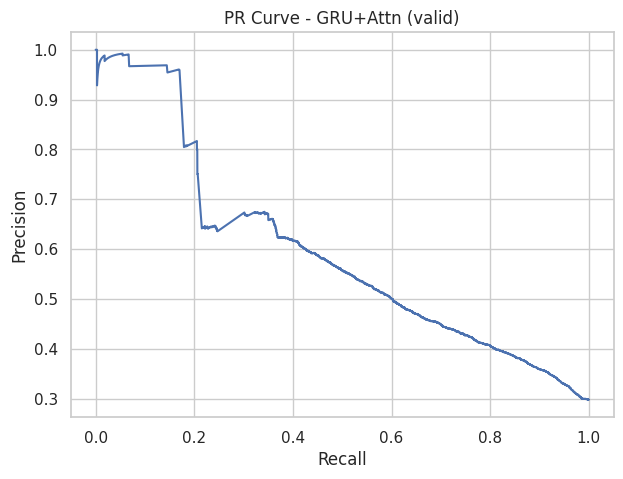

Final valid | PR-AUC: 0.5949580863112355 | ROC-AUC: 0.736185487788814


In [51]:
from sklearn.metrics import precision_recall_curve

pr, roc, ys_va, ps_va = eval_model(valid_dl)
prec, rec, _ = precision_recall_curve(ys_va, ps_va)

plt.figure(figsize=(7,5))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("PR Curve - GRU+Attn (valid)")
plt.grid(True)
plt.show()

print("Final valid | PR-AUC:", pr, "| ROC-AUC:", roc)

In [52]:
print("Sanity:")
print("- anchor month (inferred):", ANCHOR_NAME)
print("- users:", len(users))
print("- churn_rate:", float(users.is_churn.mean()))
print("- avg active days:", float(M_seq.sum())/len(users), "of", T)
print("- t0 min/max:", users.t0.min(), users.t0.max())
print("- split t0 train max:", users.loc[idx_tr,"t0"].max(), "| valid min:", users.loc[idx_va,"t0"].min())

Sanity:
- anchor month (inferred): MAR_2017
- users: 39972
- churn_rate: 0.4846392474732313
- avg active days: 9.341639147403182 of 30
- t0 min/max: 2017-03-01 00:00:00 2017-03-31 00:00:00
- split t0 train max: 2017-03-24 00:00:00 | valid min: 2017-03-26 00:00:00
